In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dairy-goods-sales-dataset/dairy_dataset.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import zscore
# Import necessary libraries for model selection
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import StackingRegressor, BaggingRegressor, AdaBoostRegressor, VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import warnings

# Filter the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")
import shap

In [3]:
# Load the dataset
df = pd.read_csv('/kaggle/input/dairy-goods-sales-dataset/dairy_dataset.csv')


In [4]:
df.head()

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,...,2021-12-27,2022-01-21,7,82.24,575.68,Madhya Pradesh,Wholesale,215,19.55,64.03
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,...,2021-10-03,2021-10-25,558,39.24,21895.92,Kerala,Wholesale,129,43.17,181.10
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,...,2022-01-14,2022-02-13,256,33.81,8655.36,Madhya Pradesh,Online,247,15.10,140.83
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,...,2019-05-15,2019-07-26,601,28.92,17380.92,Rajasthan,Online,222,74.50,57.68
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,...,2020-10-17,2020-10-28,145,83.07,12045.15,Jharkhand,Retail,2,76.02,33.40


In [5]:
df.shape

(4325, 23)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4325 entries, 0 to 4324
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Location                             4325 non-null   object 
 1   Total Land Area (acres)              4325 non-null   float64
 2   Number of Cows                       4325 non-null   int64  
 3   Farm Size                            4325 non-null   object 
 4   Date                                 4325 non-null   object 
 5   Product ID                           4325 non-null   int64  
 6   Product Name                         4325 non-null   object 
 7   Brand                                4325 non-null   object 
 8   Quantity (liters/kg)                 4325 non-null   float64
 9   Price per Unit                       4325 non-null   float64
 10  Total Value                          4325 non-null   float64
 11  Shelf Life (days)             

We observe that date is considered as obect data type. So lets convert it to datetime data type.

In [7]:
df['Date'] = pd.to_datetime(df['Date'])
df['Production Date'] = pd.to_datetime(df['Date'])
df['Expiration Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4325 entries, 0 to 4324
Data columns (total 23 columns):
 #   Column                               Non-Null Count  Dtype         
---  ------                               --------------  -----         
 0   Location                             4325 non-null   object        
 1   Total Land Area (acres)              4325 non-null   float64       
 2   Number of Cows                       4325 non-null   int64         
 3   Farm Size                            4325 non-null   object        
 4   Date                                 4325 non-null   datetime64[ns]
 5   Product ID                           4325 non-null   int64         
 6   Product Name                         4325 non-null   object        
 7   Brand                                4325 non-null   object        
 8   Quantity (liters/kg)                 4325 non-null   float64       
 9   Price per Unit                       4325 non-null   float64       
 10  Total Value 

In [8]:
df.describe()

,Total Land Area (acres),Number of Cows,Date,Product ID,Quantity (liters/kg),Price per Unit,Total Value,Shelf Life (days),Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
count,4325.000000,4325.000000,4325,4325.000000,4325.000000,4325.000000,4325.000000,4325.000000,4325,4325,4325.000000,4325.00000,4325.000000,4325.000000,4325.000000,4325.000000
mean,503.483073,54.963699,2020-12-15 22:59:04.231213824,5.509595,500.652657,54.785938,27357.845411,29.127630,2020-12-15 22:59:04.231213824,2020-12-15 22:59:04.231213824,248.095029,54.77914,13580.265401,252.068671,55.826143,109.107820
min,10.170000,10.000000,2019-01-01 00:00:00,1.000000,1.170000,10.030000,42.516500,1.000000,2019-01-01 00:00:00,2019-01-01 00:00:00,1.000000,5.21000,12.540000,0.000000,10.020000,20.020000
25%,252.950000,32.000000,2019-12-20 00:00:00,3.000000,254.170000,32.460000,9946.814500,10.000000,2019-12-20 00:00:00,2019-12-20 00:00:00,69.000000,32.64000,2916.650000,66.000000,32.910000,64.280000
50%,509.170000,55.000000,2020-12-02 00:00:00,6.000000,497.550000,54.400000,21869.652900,22.000000,2020-12-02 00:00:00,2020-12-02 00:00:00,189.000000,54.14000,8394.540000,191.000000,56.460000,108.340000
75%,751.250000,77.000000,2021-12-15 00:00:00,8.000000,749.780000,77.460000,40954.441000,30.000000,2021-12-15 00:00:00,2021-12-15 00:00:00,374.000000,77.46000,19504.550000,387.000000,79.010000,153.390000
max,999.530000,100.000000,2022-12-28 00:00:00,10.000000,999.930000,99.990000,99036.369600,150.000000,2022-12-28 00:00:00,2022-12-28 00:00:00,960.000000,104.51000,89108.900000,976.000000,99.990000,199.950000
std,285.935061,26.111487,NaN,2.842979,288.975915,26.002815,21621.051594,30.272114,NaN,NaN,217.024182,26.19279,14617.009122,223.620870,26.301450,51.501035


In [9]:
df.describe(include="all")

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Production Date,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg)
count,4325,4325.000000,4325.000000,4325,4325,4325.000000,4325,4325,4325.000000,4325.000000,...,4325,4325,4325.000000,4325.00000,4325.000000,4325,4325,4325.000000,4325.000000,4325.000000
unique,15,NaN,NaN,3,NaN,NaN,10,11,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,15,3,NaN,NaN,NaN
top,Delhi,NaN,NaN,Large,NaN,NaN,Curd,Amul,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,Delhi,Retail,NaN,NaN,NaN
freq,525,NaN,NaN,1462,NaN,NaN,479,1053,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,499,1478,NaN,NaN,NaN
mean,NaN,503.483073,54.963699,NaN,2020-12-15 22:59:04.231213824,5.509595,NaN,NaN,500.652657,54.785938,...,2020-12-15 22:59:04.231213824,2020-12-15 22:59:04.231213824,248.095029,54.77914,13580.265401,NaN,NaN,252.068671,55.826143,109.107820
min,NaN,10.170000,10.000000,NaN,2019-01-01 00:00:00,1.000000,NaN,NaN,1.170000,10.030000,...,2019-01-01 00:00:00,2019-01-01 00:00:00,1.000000,5.21000,12.540000,NaN,NaN,0.000000,10.020000,20.020000
25%,NaN,252.950000,32.000000,NaN,2019-12-20 00:00:00,3.000000,NaN,NaN,254.170000,32.460000,...,2019-12-20 00:00:00,2019-12-20 00:00:00,69.000000,32.64000,2916.650000,NaN,NaN,66.000000,32.910000,64.280000
50%,NaN,509.170000,55.000000,NaN,2020-12-02 00:00:00,6.000000,NaN,NaN,497.550000,54.400000,...,2020-12-02 00:00:00,2020-12-02 00:00:00,189.000000,54.14000,8394.540000,NaN,NaN,191.000000,56.460000,108.340000
75%,NaN,751.250000,77.000000,NaN,2021-12-15 00:00:00,8.000000,NaN,NaN,749.780000,77.460000,...,2021-12-15 00:00:00,2021-12-15 00:00:00,374.000000,77.46000,19504.550000,NaN,NaN,387.000000,79.010000,153.390000
max,NaN,999.530000,100.000000,NaN,2022-12-28 00:00:00,10.000000,NaN,NaN,999.930000,99.990000,...,2022-12-28 00:00:00,2022-12-28 00:00:00,960.000000,104.51000,89108.900000,NaN,NaN,976.000000,99.990000,199.950000


In [10]:
df.isnull().sum()

Location                               0
Total Land Area (acres)                0
Number of Cows                         0
Farm Size                              0
Date                                   0
Product ID                             0
Product Name                           0
Brand                                  0
Quantity (liters/kg)                   0
Price per Unit                         0
Total Value                            0
Shelf Life (days)                      0
Storage Condition                      0
Production Date                        0
Expiration Date                        0
Quantity Sold (liters/kg)              0
Price per Unit (sold)                  0
Approx. Total Revenue(INR)             0
Customer Location                      0
Sales Channel                          0
Quantity in Stock (liters/kg)          0
Minimum Stock Threshold (liters/kg)    0
Reorder Quantity (liters/kg)           0
dtype: int64

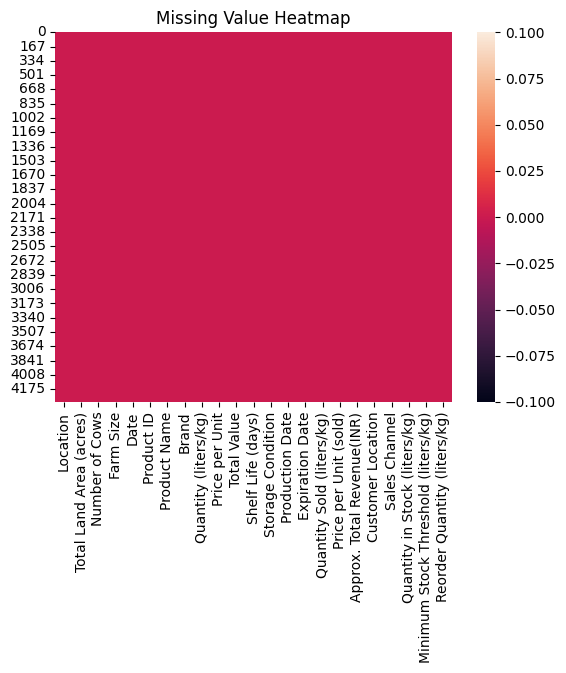

In [11]:
sns.heatmap(df.isnull())
plt.title('Missing Value Heatmap')
plt.show()

In [12]:
print("Duplicate Values =",df.duplicated().sum())

Duplicate Values = 0


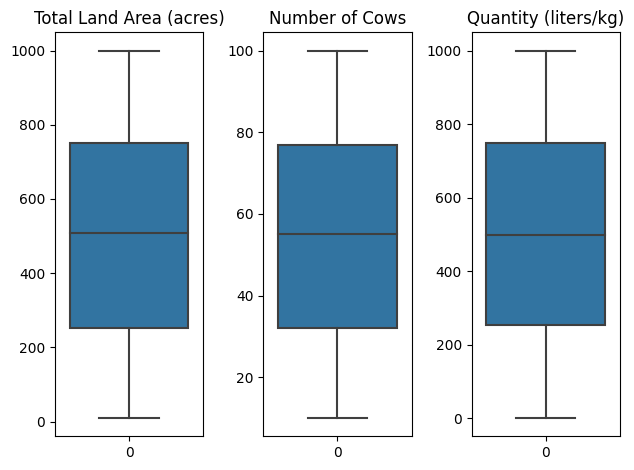

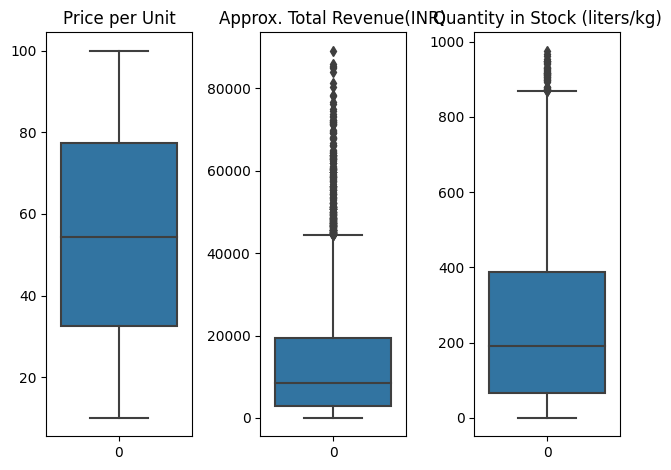

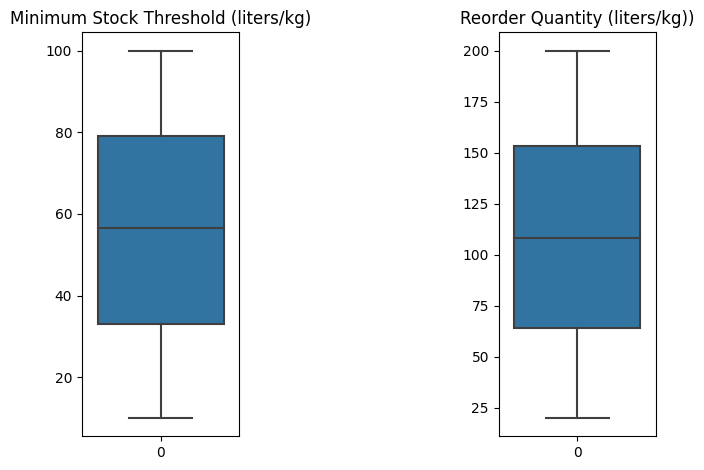

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.subplot(1,3,1)
sns.boxplot(df['Total Land Area (acres)'])
plt.title("Total Land Area (acres)")

plt.subplot(1,3,2)
sns.boxplot(df["Number of Cows"])
plt.title("Number of Cows")

plt.subplot(1,3,3)
sns.boxplot(df["Quantity (liters/kg)"])
plt.title("Quantity (liters/kg)")

plt.tight_layout()  # Adjust layout for better spacing

plt.show()

plt.subplot(1,3,1)
sns.boxplot(df["Price per Unit"])
plt.title("Price per Unit")

plt.subplot(1,3,2)
sns.boxplot(df["Approx. Total Revenue(INR)"])
plt.title("Approx. Total Revenue(INR)")

plt.subplot(1,3,3)
sns.boxplot(df["Quantity in Stock (liters/kg)"])
plt.title("Quantity in Stock (liters/kg)")

plt.tight_layout()  # Adjust layout for better spacing

plt.show()

plt.subplot(1,3,1)
sns.boxplot(df["Minimum Stock Threshold (liters/kg)"])
plt.title("Minimum Stock Threshold (liters/kg)")

plt.subplot(1,3,3)
sns.boxplot(df["Reorder Quantity (liters/kg)"])
plt.title("Reorder Quantity (liters/kg))")

plt.tight_layout()  # Adjust layout for better spacing

plt.show()

# **Classification based visualization of related features**

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


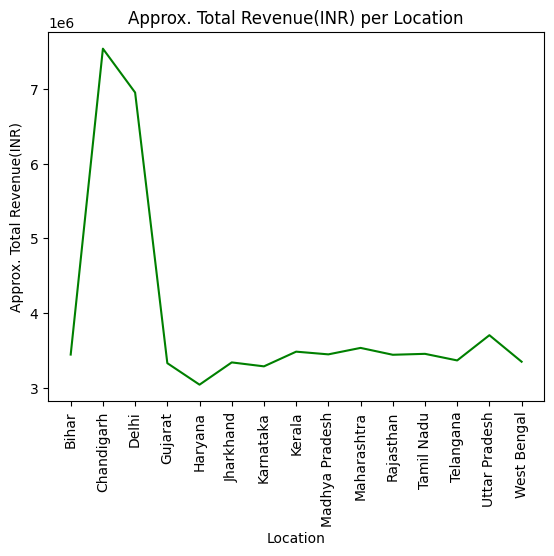

In [14]:
# Group the data by location and calculate the sum of price sold
grouped_data = df.groupby('Location')['Approx. Total Revenue(INR)'].sum().reset_index()

# Create the line chart
sns.lineplot(data=grouped_data, x='Location', y='Approx. Total Revenue(INR)', color='green')

# Set x-axis label and rotate the x-labels if needed
plt.xlabel('Location')
plt.xticks(rotation=90)

# Set y-axis label
plt.ylabel('Approx. Total Revenue(INR)')

# Set the title
plt.title("Approx. Total Revenue(INR) per Location")

# Display the plot
plt.show()



**Calculations for supply information**

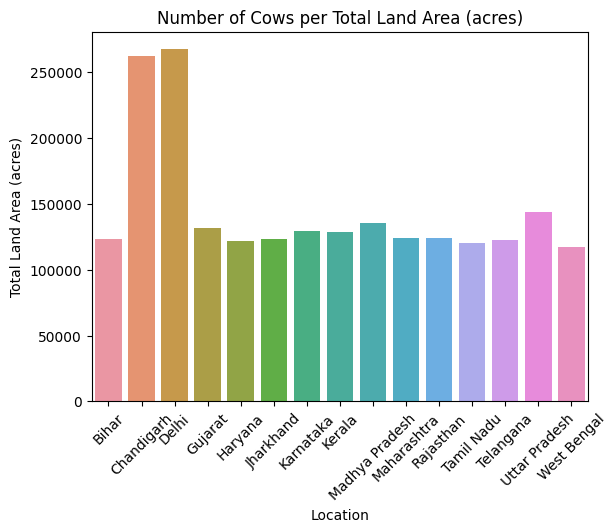

In [15]:
# Calculate the sum of "Number of Cows" per Total Land Area (acres)
sum_per_location = df.groupby("Location")["Total Land Area (acres)"].sum()

# Plot the bar chart
sns.barplot(x=sum_per_location.index, y=sum_per_location.values)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Add a label to the y-axis
plt.ylabel("Total Land Area (acres)")

plt.title("Number of Cows per Total Land Area (acres)")

# Show the plot
plt.show()

In [16]:
total_land_area = df["Total Land Area (acres)"].sum()
result_string = "This is the total land area: " + str(total_land_area)
print(result_string)

This is the total land area: 2177564.29


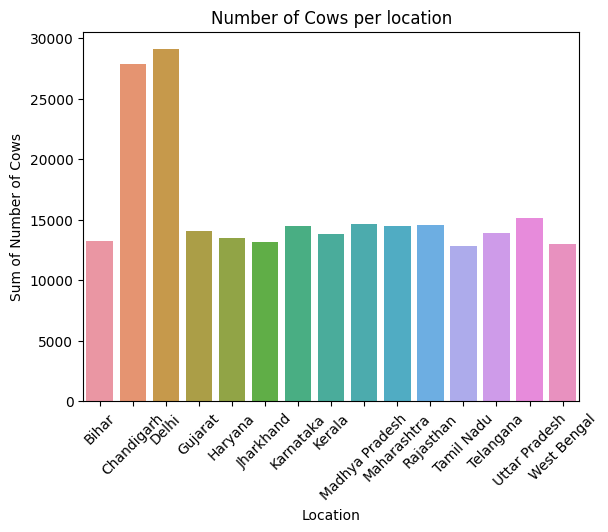

In [17]:
# Calculate the sum of "Number of Cows" per location
cow_sum_per_location = df.groupby("Location")["Number of Cows"].sum()

# Plot the bar chart
sns.barplot(x=cow_sum_per_location.index, y=cow_sum_per_location.values)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Add a label to the y-axis
plt.ylabel("Sum of Number of Cows")

plt.title("Number of Cows per location")

# Show the plot
plt.show()

# Product sales Analysis


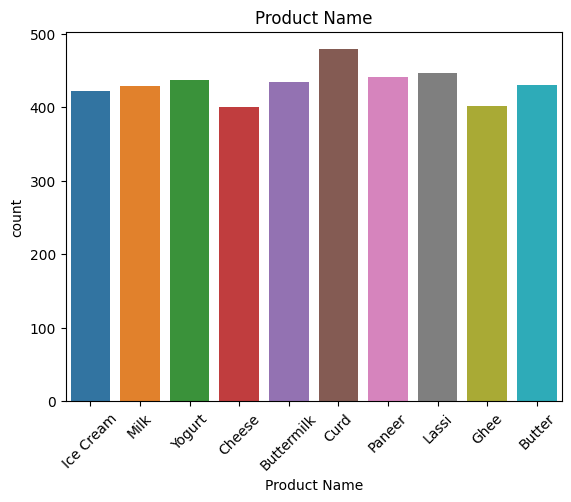

In [18]:
sns.countplot(data = df, x = "Product Name")

# Rotate the x-labels
plt.xticks(rotation=45)  # Specify the rotation angle in degrees
plt.title("Product Name")

# Show the plot
plt.show()

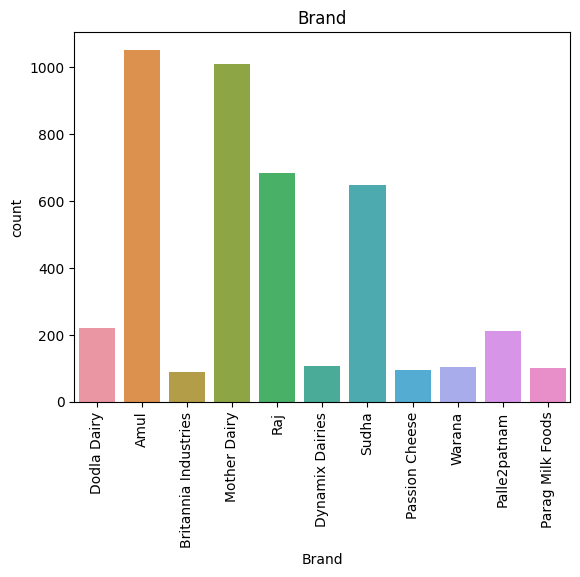

In [19]:
sns.countplot(data = df, x = "Brand")

# Rotate the x-labels
plt.xticks(rotation=90)  # Specify the rotation angle in degrees
plt.title("Brand")

# Show the plot
plt.show()

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping wi

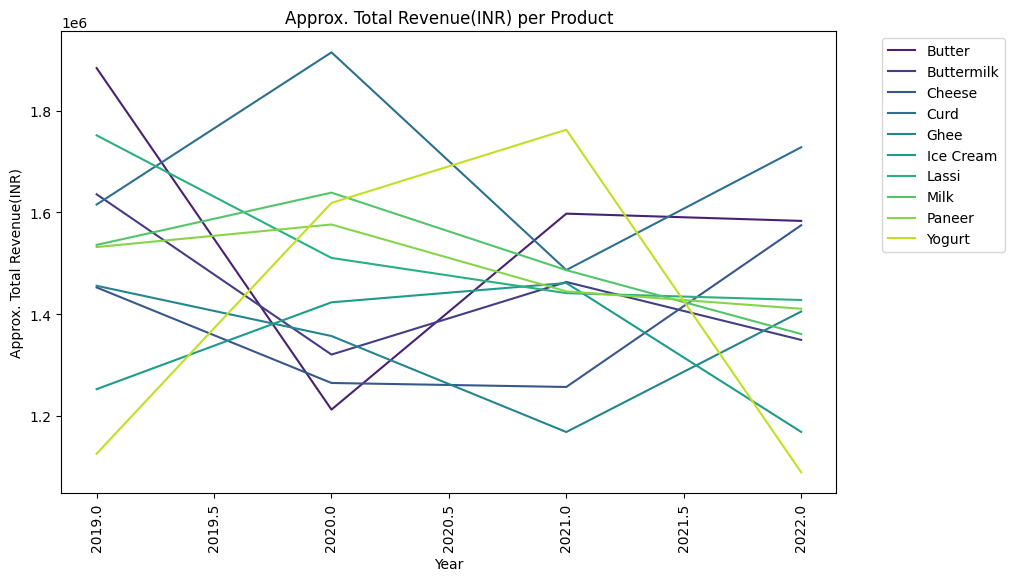

In [20]:
# Convert 'Date' column to datetime if needed
df['Date'] = pd.to_datetime(df['Date'])

# Create 'Year' column
df['Year'] = df['Date'].dt.year

# Group the data by Year and Product Name and calculate the sum of Approx. Total Revenue(INR)
grouped_data_product = df.groupby(['Year', 'Product Name'])['Approx. Total Revenue(INR)'].sum().reset_index()

# Set the figure size
plt.figure(figsize=(10, 6))

# Create the line chart
sns.lineplot(data=grouped_data_product, x='Year', y='Approx. Total Revenue(INR)', hue='Product Name', palette='viridis')

# Set x-axis label and rotate the x-labels if needed
plt.xlabel('Year')
plt.xticks(rotation=90)

# Set y-axis label
plt.ylabel('Approx. Total Revenue(INR)')

# Adjust the position of the legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Approx. Total Revenue(INR) per Product")

# Display the plot
plt.show()

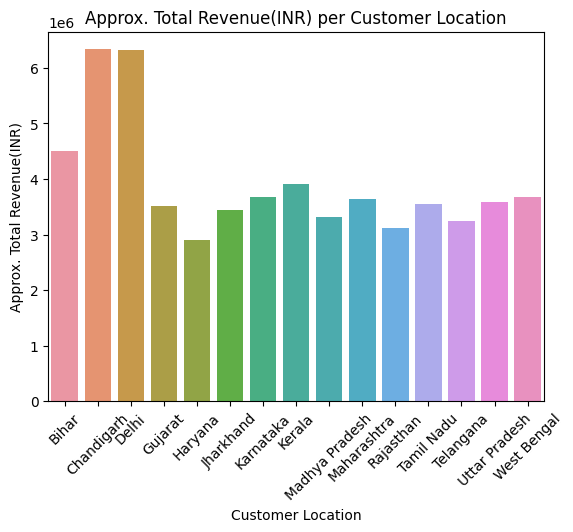

In [21]:
# Calculate the sum of "Approx. Total Revenue(INR)" per Customer Location
sum_per_location = df.groupby("Customer Location")["Approx. Total Revenue(INR)"].sum()

# Plot the bar chart
sns.barplot(x=sum_per_location.index, y=sum_per_location.values)

# Rotate the x-axis labels
plt.xticks(rotation=45)

# Add a label to the y-axis
plt.ylabel("Approx. Total Revenue(INR)")

plt.title("Approx. Total Revenue(INR) per Customer Location")

# Show the plot
plt.show()

In [22]:
label_encoder = LabelEncoder()

# Fit and transform the Location column
df['Customer Location'] = label_encoder.fit_transform(df['Customer Location'])

# Check the label mapping if needed
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Label mapping:", label_mapping)

Label mapping: {'Bihar': 0, 'Chandigarh': 1, 'Delhi': 2, 'Gujarat': 3, 'Haryana': 4, 'Jharkhand': 5, 'Karnataka': 6, 'Kerala': 7, 'Madhya Pradesh': 8, 'Maharashtra': 9, 'Rajasthan': 10, 'Tamil Nadu': 11, 'Telangana': 12, 'Uttar Pradesh': 13, 'West Bengal': 14}


In [23]:
df.head()

,Location,Total Land Area (acres),Number of Cows,Farm Size,Date,Product ID,Product Name,Brand,Quantity (liters/kg),Price per Unit,...,Expiration Date,Quantity Sold (liters/kg),Price per Unit (sold),Approx. Total Revenue(INR),Customer Location,Sales Channel,Quantity in Stock (liters/kg),Minimum Stock Threshold (liters/kg),Reorder Quantity (liters/kg),Year
0,Telangana,310.84,96,Medium,2022-02-17,5,Ice Cream,Dodla Dairy,222.40,85.72,...,2022-02-17,7,82.24,575.68,8,Wholesale,215,19.55,64.03,2022
1,Uttar Pradesh,19.19,44,Large,2021-12-01,1,Milk,Amul,687.48,42.61,...,2021-12-01,558,39.24,21895.92,7,Wholesale,129,43.17,181.10,2021
2,Tamil Nadu,581.69,24,Medium,2022-02-28,4,Yogurt,Dodla Dairy,503.48,36.50,...,2022-02-28,256,33.81,8655.36,8,Online,247,15.10,140.83,2022
3,Telangana,908.00,89,Small,2019-06-09,3,Cheese,Britannia Industries,823.36,26.52,...,2019-06-09,601,28.92,17380.92,10,Online,222,74.50,57.68,2019
4,Maharashtra,861.95,21,Medium,2020-12-14,8,Buttermilk,Mother Dairy,147.77,83.85,...,2020-12-14,145,83.07,12045.15,5,Retail,2,76.02,33.40,2020


In [24]:
# Group by Product Name and Customer Location, then calculate total quantity sold and revenue
df_grouped = df.groupby(['Product Name', 'Customer Location']).agg(
    total_quantity_sold=('Quantity Sold (liters/kg)', 'sum'),
    total_revenue=('Approx. Total Revenue(INR)', 'sum')
).reset_index()

# Check the grouped data
print(df_grouped)


    Product Name  Customer Location  total_quantity_sold  total_revenue
0         Butter                  0                 9735      532330.77
1         Butter                  1                11590      646864.93
2         Butter                  2                13666      781000.76
3         Butter                  3                 5296      243322.98
4         Butter                  4                 7904      463021.72
..           ...                ...                  ...            ...
145       Yogurt                 10                 6419      435963.26
146       Yogurt                 11                 6343      350851.96
147       Yogurt                 12                 8412      347734.63
148       Yogurt                 13                 1865       99157.85
149       Yogurt                 14                 4413      201879.28

[150 rows x 4 columns]


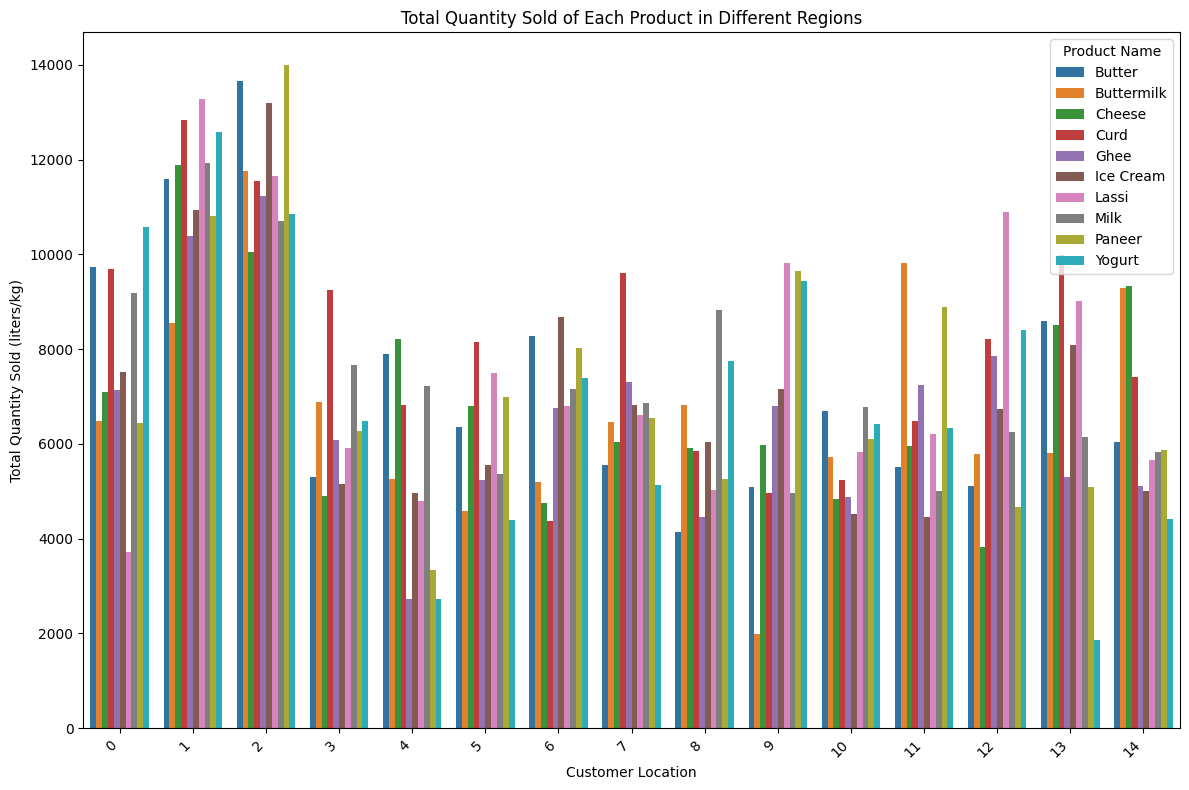

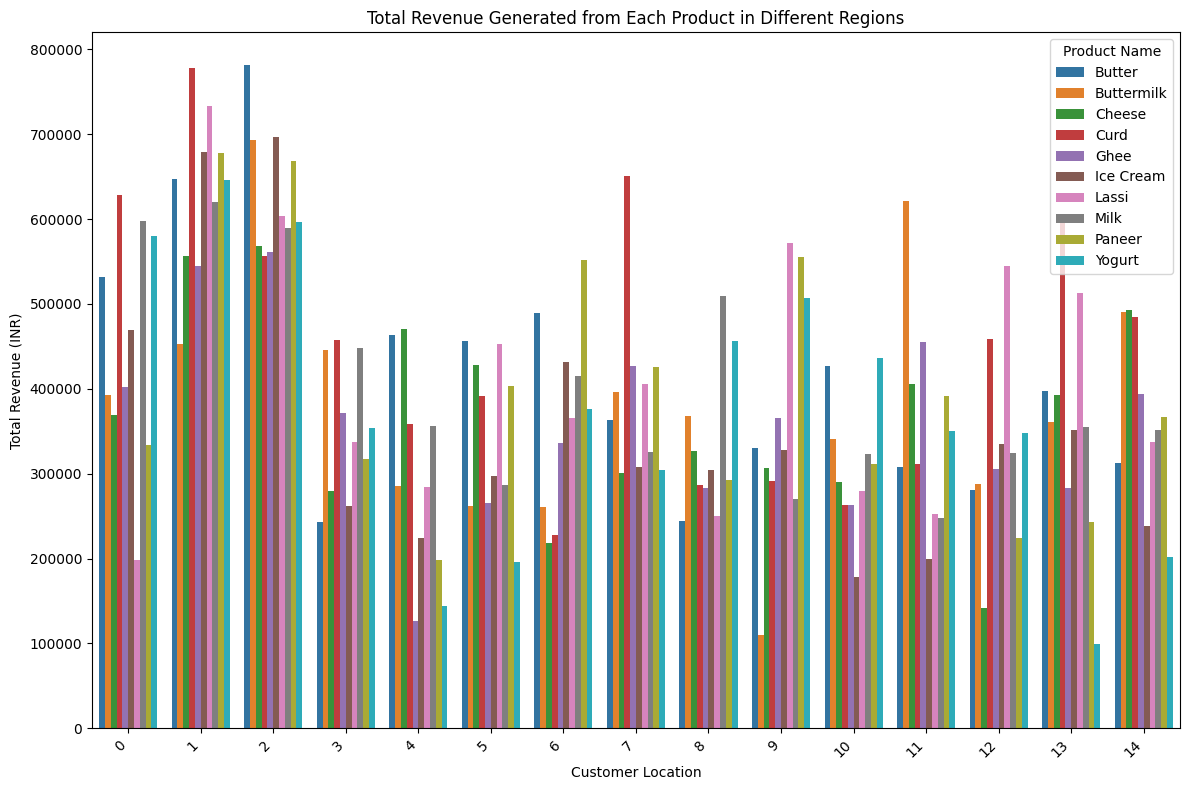

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a barplot to visualize the quantity sold for each product in each region
plt.figure(figsize=(12, 8))
sns.barplot(x='Customer Location', y='total_quantity_sold', hue='Product Name', data=df_grouped)

# Add title and labels
plt.title('Total Quantity Sold of Each Product in Different Regions')
plt.xlabel('Customer Location')
plt.ylabel('Total Quantity Sold (liters/kg)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Create another barplot to visualize the revenue generated from each product in each region
plt.figure(figsize=(12, 8))
sns.barplot(x='Customer Location', y='total_revenue', hue='Product Name', data=df_grouped)

# Add title and labels
plt.title('Total Revenue Generated from Each Product in Different Regions')
plt.xlabel('Customer Location')
plt.ylabel('Total Revenue (INR)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Product sales Prediction

In [26]:
#Creating some new columns that help in prediction like time-stamps
# Make sure 'Date' column is in datetime format
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Extract year, month, and weekday from 'Date'
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Weekday'] = df['Date'].dt.weekday  # Monday=0, Sunday=6

# Check the DataFrame to confirm the new columns
print(df[['Date', 'Year', 'Month', 'Weekday']].head())


        Date  Year  Month  Weekday
0 2022-02-17  2022      2        3
1 2021-12-01  2021     12        2
2 2022-02-28  2022      2        0
3 2019-06-09  2019      6        6
4 2020-12-14  2020     12        0


In [27]:
# train-test split
from sklearn.model_selection import train_test_split
# Select features and target
X = df_grouped[['Product Name', 'Customer Location']]  # Features
y = df_grouped['total_quantity_sold']  # Target variable (or 'total_revenue')

# Convert categorical columns to numeric
X = pd.get_dummies(X, columns=['Product Name', 'Customer Location'], drop_first=True)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [28]:
from sklearn.ensemble import RandomForestRegressor

# Initialize and train the model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

print(f'MAE: {mae}, RMSE: {rmse}, R²: {r2}')

MAE: 1792.304, RMSE: 2378.8285282270067, R²: 0.2718103885802141


In [29]:
from statsmodels.tsa.arima.model import ARIMA

# Prepare time series data
ts_data = df.groupby('Date')['Approx. Total Revenue(INR)'].sum()  # Sum by date (if needed)
ts_data = ts_data.asfreq('D')  # If you want daily data, adjust frequency

# Fit the ARIMA model (order (p,d,q) needs tuning)
model = ARIMA(ts_data, order=(5,1,0))  # Adjust p, d, q
model_fit = model.fit()

# Forecast future values
forecast = model_fit.forecast(steps=30)  # Predict the next 30 days
print(forecast)

2022-12-29    48253.502945
2022-12-30    48488.756791
2022-12-31    49021.042934
2023-01-01    47223.351435
2023-01-02    52939.848417
2023-01-03    56484.408337
2023-01-04    50078.116166
2023-01-05    50690.540495
2023-01-06    50992.356660
2023-01-07    51246.689652
2023-01-08    52252.078574
2023-01-09    52020.156794
2023-01-10    51146.636892
2023-01-11    51383.872706
2023-01-12    51488.453416
2023-01-13    51588.286645
2023-01-14    51678.248895
2023-01-15    51549.685407
2023-01-16    51460.404756
2023-01-17    51523.550635
2023-01-18    51546.682028
2023-01-19    51560.823895
2023-01-20    51557.136976
2023-01-21    51531.059627
2023-01-22    51528.098515
2023-01-23    51541.296235
2023-01-24    51544.420943
2023-01-25    51544.537697
2023-01-26    51541.327668
2023-01-27    51537.931490
Freq: D, Name: predicted_mean, dtype: float64


Mean Squared Error: 160620.3595897027
R-squared Score: 0.9992049462479694


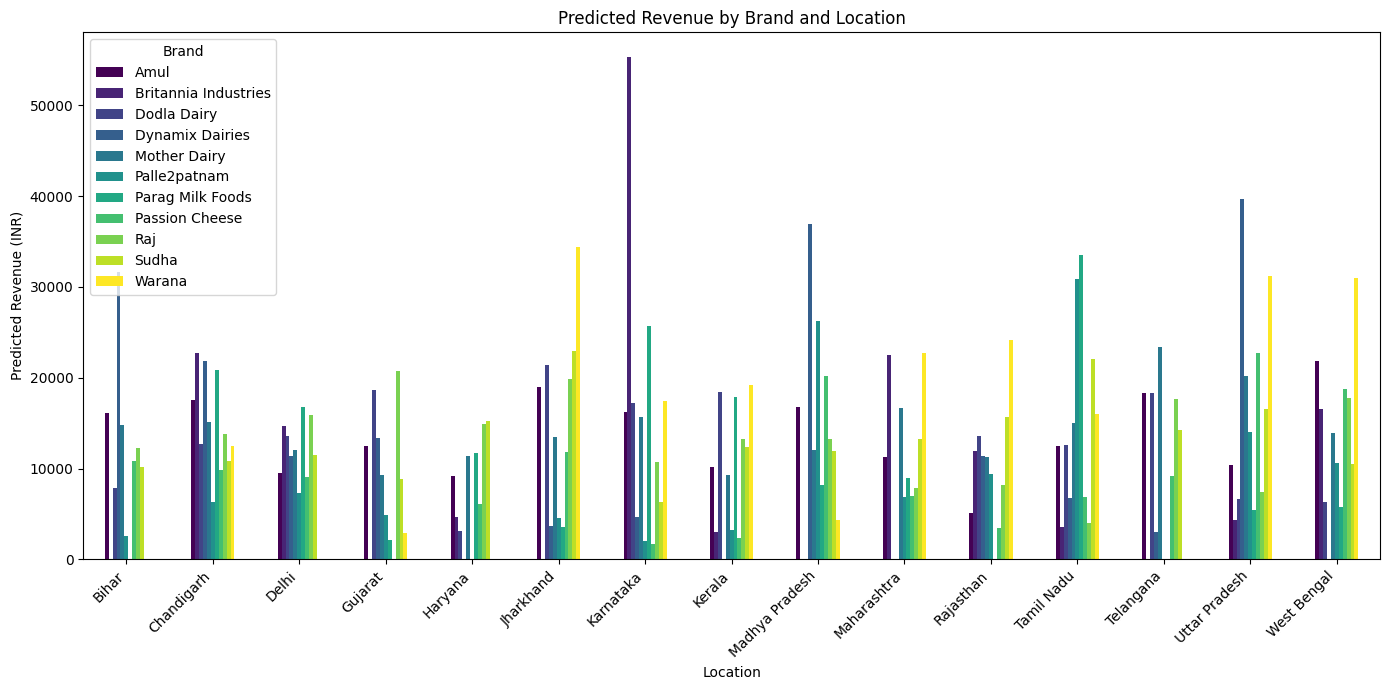

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load the dataset
data = pd.read_csv('/kaggle/input/dairy-goods-sales-dataset/dairy_dataset.csv')

# Step 2: Encode categorical data
label_encoder_location = LabelEncoder()
label_encoder_brand = LabelEncoder()

data['Location'] = label_encoder_location.fit_transform(data['Location'])
data['Brand'] = label_encoder_brand.fit_transform(data['Brand'])

# Step 3: Select features and target variable
X = data[['Location', 'Brand', 'Quantity Sold (liters/kg)', 'Price per Unit (sold)']]
y = data['Approx. Total Revenue(INR)']

# Step 4: Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 5: Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 6: Train the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

# Step 7: Make predictions on the test set
y_pred = model.predict(X_test_scaled)

# Ensure non-negative predictions
y_pred = [max(0, value) for value in y_pred]

# Step 8: Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R-squared Score:", r2)

# Step 9: Create a DataFrame for predictions
X_test['Predicted Revenue (INR)'] = y_pred
X_test['Location'] = label_encoder_location.inverse_transform(X_test['Location'].astype(int))
X_test['Brand'] = label_encoder_brand.inverse_transform(X_test['Brand'].astype(int))

# Step 10: Plot the predictions
grouped_data = X_test.groupby(['Location', 'Brand'])['Predicted Revenue (INR)'].mean().unstack()

# Plot a grouped bar chart
grouped_data.plot(kind='bar', figsize=(14, 7), colormap='viridis')
plt.title('Predicted Revenue by Brand and Location')
plt.xlabel('Location')
plt.ylabel('Predicted Revenue (INR)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()